In [6]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
# path, emotion label, domain label (RAVDESS 0, TESS 1)

# RAVDESS: 80/10/10 as usual
# TESS: 80 of each emotion * 7 = 560 (20% of 2800), 90/10 for training/validation, remaining 80% of data for testing

Ravdess = "C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/3_SER_datasets/Raw_datasets/RAVDESS/audio_speech_actors_01-24/"
Tess = "C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/3_SER_datasets/Raw_datasets/TESS/"

ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
domain_column = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0] # e.g., 03-01-06-01-01-01-01
        part = part.split('-')
        # extract the third section as emotion
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        domain_column.append(0) # domain 0

emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
domain_df = pd.DataFrame(domain_column, columns=['Domain'])
Ravdess_df = pd.concat([path_df, emotion_df, domain_df], axis=1)

Ravdess_df.Emotion.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', \
                            7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.Emotion.replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, \
                          'disgust':7, 'surprise':0}, inplace=True)

# -------------------------------------------------------------------------------- #

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []
domain_column = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)

        file_path.append(Tess + dir + '/' + file)
        domain_column.append(1) # domain 1

emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['Path'])
domain_df = pd.DataFrame(domain_column, columns=['Domain'])
Tess_df = pd.concat([path_df, emotion_df, domain_df], axis=1)

Tess_df.Emotion.replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, \
                          'disgust':7, 'surprise':0}, inplace=True)

# combined_df = pd.concat([Ravdess_df, Tess_df], axis=0, ignore_index=True)
# combined_df.Emotion.replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, \
#                             'disgust':7, 'surprise':0}, inplace=True)

# combined_df

Ravdess_df


,Path,Emotion,Domain
0,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,1,0
1,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,1,0
2,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,1,0
3,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,1,0
4,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,2,0
...,...,...,...
1435,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,0,0
1436,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,0,0
1437,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,0,0
1438,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,0,0


In [8]:
# plt.title('Count of Emotions', size=16)
# sns.countplot(x=Tess_df["Emotion"])
# plt.ylabel('Count', size=12)
# plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()

# TESS does not have 'calm'

In [9]:
## Take only 54 x 8 = 432 of RAVDESS data 

# Grouping the DataFrame by 'Emotion'
grouped_df = Ravdess_df.groupby('Emotion')

sampled_dfs = []
remaining_dfs = []

# Loop through each group (emotion)
for emotion, group_df in grouped_df:
    # If there are fewer than 80 samples for an emotion, use all available samples
    if len(group_df) <= 54:
        sampled_df = group_df
        remaining_df = pd.DataFrame() # Empty DataFrame for remaining rows
    else:
        # Randomly sample 80 rows for each emotion
        sampled_df = group_df.sample(n=54, random_state=42)  # Set random_state for reproducibility
        remaining_df = group_df.drop(sampled_df.index)
    sampled_dfs.append(sampled_df)
    remaining_dfs.append(remaining_df)

# Concatenate the DataFrames
Ravdess_30p_df = pd.concat(sampled_dfs)
Ravdess_test_df = pd.concat(remaining_dfs)

# Reset index
Ravdess_30p_df.reset_index(drop=True, inplace=True)
Ravdess_test_df.reset_index(drop=True, inplace=True)

print(Ravdess_30p_df)
print(Ravdess_test_df)

                                                  Path  Emotion  Domain
0    C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        0       0
1    C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        0       0
2    C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        0       0
3    C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        0       0
4    C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        0       0
..                                                 ...      ...     ...
427  C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        7       0
428  C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        7       0
429  C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        7       0
430  C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        7       0
431  C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...        7       0

[432 rows x 3 columns]
                                                   Path  Emotion  Domain
0     C:/Users/daryl/Documents/Desktop/

In [10]:
combined_df = pd.concat([Tess_df, Ravdess_30p_df], axis=0, ignore_index=True)
combined_df.Emotion.replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, \
                            'disgust':7, 'surprise':0}, inplace=True)

combined_df

,Path,Emotion,Domain
0,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,5,1
1,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,5,1
2,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,5,1
3,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,5,1
4,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,5,1
...,...,...,...
3227,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,7,0
3228,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,7,0
3229,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,7,0
3230,C:/Users/daryl/Documents/Desktop/2_EE4002D FYP...,7,0


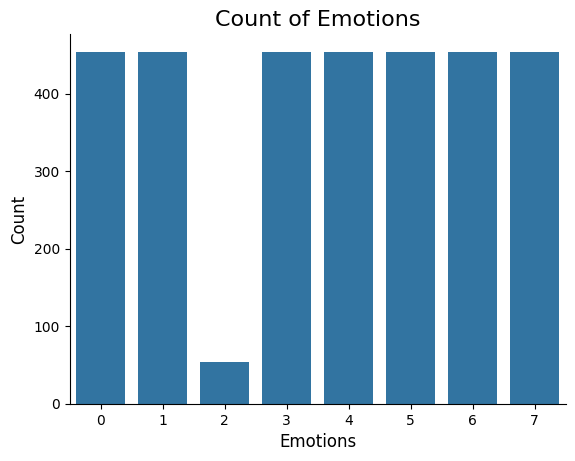

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=combined_df["Emotion"])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
mel_spectrograms = []

SAMPLE_RATE = 48000

ravdess_30p_signals = []
for i, file_path in enumerate(Ravdess_30p_df.Path):
    audio, sample_rate = librosa.load(file_path, duration=3.5, offset=0, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3.5,)))

    # Use librosa.effects.trim to trim silent sections
    audio_trimmed, index = librosa.effects.trim(audio, top_db=18)  # Adjust 'top_db' as needed

    signal[:len(audio_trimmed)] = audio_trimmed
    ravdess_30p_signals.append(signal)
    print("\r Processed {}/{} {} files".format(i,len(Ravdess_30p_df), "Ravdess 30%"),end='')
ravdess_30p_signals = np.stack(ravdess_30p_signals,axis=0)
print('\n')

ravdess_test_signals = []
for i, file_path in enumerate(Ravdess_test_df.Path):
    audio, sample_rate = librosa.load(file_path, duration=3.5, offset=0, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3.5,)))

    # Use librosa.effects.trim to trim silent sections
    audio_trimmed, index = librosa.effects.trim(audio, top_db=18)  # Adjust 'top_db' as needed

    signal[:len(audio_trimmed)] = audio_trimmed
    ravdess_test_signals.append(signal)
    print("\r Processed {}/{} {} files".format(i,len(Ravdess_test_df), "Ravdess test"),end='')
ravdess_test_signals = np.stack(ravdess_test_signals,axis=0)

tess_signals = []
for i, file_path in enumerate(Tess_df.Path):
    audio, sample_rate = librosa.load(file_path, duration=3.5, offset=0, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3.5,)))
    audio_trimmed, index = librosa.effects.trim(audio, top_db=18)  # Adjust 'top_db' as needed
    signal[:len(audio_trimmed)] = audio_trimmed
    tess_signals.append(signal)
    print("\r Processed {}/{} {} files".format(i,len(Tess_df), "Tess"),end='')
tess_signals = np.stack(tess_signals,axis=0)

total_TrVal_signals = np.vstack((tess_signals, ravdess_30p_signals))
print('\n', total_TrVal_signals.shape)
print(ravdess_test_signals.shape)

 Processed 431/432 Ravdess 30% files

 Processed 2799/2800 Tess filesst files
 (3232, 168000)
(1008, 168000)


In [13]:
# Z = combined_df['Domain'].to_numpy(dtype=np.int32)
# Z, Z.shape

In [14]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
X = total_TrVal_signals
Z = combined_df['Domain'].to_numpy(dtype=np.int32)
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[] # signal
Y_train,Y_val,Y_test = [],[],[] # emotion label
Z_train,Z_val,Z_test = [],[],[] # domain label

Ravdess_X_test = ravdess_test_signals
Ravdess_Y_test = Ravdess_test_df['Emotion'].values
Ravdess_Z_test = Ravdess_test_df['Domain'].values

print(f'Ravdess_X_test:{Ravdess_X_test.shape}, Ravdess_Y_test:{Ravdess_Y_test.shape}, Ravdess_Z_test:{Ravdess_Z_test.shape}')


for emotion in range(len(EMOTIONS)):
    emotion_ind = list(combined_df.loc[combined_df.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]

    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    Z_train.append(Z[ind_train])

    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    Z_val.append(Z[ind_val])

    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    Z_test.append(Z[ind_test])

    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)

X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
Z_train = np.concatenate(Z_train,0)
Z_val = np.concatenate(Z_val,0)
Z_test = np.concatenate(Z_test,0)

train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}, Z_train:{Z_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}, Z_val:{Z_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}, Z_test:{Z_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

Ravdess_X_test:(1008, 168000), Ravdess_Y_test:(1008,), Ravdess_Z_test:(1008,)


X_train:(2584, 168000), Y_train:(2584,), Z_train:(2584,)
X_val:(320, 168000), Y_val:(320,), Z_val:(320,)
X_test:(328, 168000), Y_test:(328,), Z_test:(328,)
Number of unique indexes is 3232, out of 3232


In [15]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K
    # Generate noisy signal
    return signal + K.T * noise

In [16]:
aug_signals = []
aug_emotion_labels = []
aug_domain_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_emotion_labels.append(combined_df.loc[i,"Emotion"])
        aug_domain_labels.append(combined_df.loc[i,"Domain"])
        aug_signals.append(augmented_signals[j,:])
        # data_path = data_path.append(data_path.iloc[i], ignore_index=True)
        pd.concat([combined_df, combined_df.iloc[i]])
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train = np.concatenate([X_train,aug_signals],axis=0)
aug_emotion_labels = np.stack(aug_emotion_labels,axis=0)
Y_train = np.concatenate([Y_train,aug_emotion_labels])
aug_domain_labels = np.stack(aug_domain_labels,axis=0)
Z_train = np.concatenate([Z_train,aug_domain_labels])
print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}, Z_train:{Z_train.shape}')

 Processed 2583/2584 files
X_train:(7752, 168000), Y_train:(7752,), Z_train:(7752,)


In [17]:
def avg_of_nested_list(double_nested_list):
    averages = []

    # Iterate over the inner lists
    for inner_list in double_nested_list:
        # Calculate the average of each inner list
        if len(inner_list) > 0:
            avg = [sum(inner_list) / len(inner_list)]
            averages.append(avg)
        else:
            # Handle the case of an empty inner list (avoid division by zero)
            averages.append(0.0)

    return averages

In [18]:
scaler = MinMaxScaler()
def getMFCC(audio, sample_rate, n_mfcc):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfcc_db = librosa.power_to_db(mfcc, ref=np.max)
    result = scaler.fit_transform(mfcc_db)
    return result

In [19]:
def getMELspectrogram(audio, sample_rate, n_mels):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    result = scaler.fit_transform(mel_spec_db)
    return result

In [20]:
def getChroma(audio, sample_rate, n_chroma):
    stft = np.abs(librosa.stft(audio))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=n_chroma)
    chroma_db = librosa.power_to_db(chroma, ref=np.max)
    result = scaler.fit_transform(chroma_db)
    return result

In [21]:
def getSpectralContrast(audio, sample_rate, n_bands):
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_bands=n_bands)
    spectral_contrast_db = librosa.power_to_db(spectral_contrast, ref=np.max)
    result = scaler.fit_transform(spectral_contrast_db)
    return result

In [22]:
def getTonnetz(audio, sample_rate):
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
    # tonnetz_db = librosa.power_to_db(tonnetz, ref=np.max)
    result = scaler.fit_transform(tonnetz)
    return result

In [23]:
def five_feature_transform(audio, sample_rate):

    # Extract MFCCs (Mel-frequency cepstral coefficients)
    mfccs = getMFCC(audio, sample_rate, 20) # (20x188)
    mfccs = avg_of_nested_list(mfccs) # (20, 1)

    # Extract Mel-scaled spectrogram (N frequency bins)
    mel_spectrogram = getMELspectrogram(audio, sample_rate, 148) # (148x188)
    mel_spectrogram = avg_of_nested_list(mel_spectrogram)

    # Extract Chromagram (12 bins)
    chromagram = getChroma(audio, sample_rate, 12) # (12x188)
    chromagram = avg_of_nested_list(chromagram)

    # Extract Spectral contrast feature (6 bins)
    spectral_contrast = getSpectralContrast(audio, sample_rate, 6) # 5-7
    spectral_contrast = avg_of_nested_list(spectral_contrast)

    # Extract Tonnetz representation (6 dimensions)
    tonnetz = getTonnetz(audio, sample_rate)
    tonnetz = avg_of_nested_list(tonnetz)

    # ---------  20 + 148 + 12 + 7 + 6 = 193  ----------- #

    # Stack the features vertically (along the rows)
    combined_features = np.vstack((mfccs, mel_spectrogram, chromagram, spectral_contrast, tonnetz)) # 193x1
    combined_features = combined_features.transpose() # 1x193
    return combined_features

# Test
emotion = 1
path = np.array(combined_df.Path[combined_df.Emotion==emotion])[50]
print(path)
audio, sample_rate = librosa.load(combined_df.loc[0,'Path'], duration=3.5, sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3.5,)))
signal[:len(audio)] = audio
five_features = five_feature_transform(signal, SAMPLE_RATE)
print('5 features transform shape: ', five_features.shape)


C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/3_SER_datasets/Raw_datasets/TESS/OAF_neutral/OAF_good_neutral.wav
5 features transform shape:  (1, 193)


In [24]:
five_features_train = []
print("Calculating 5 features for train set")
for i in range(X_train.shape[0]):
    five_feature = five_feature_transform(X_train[i,:], sample_rate=SAMPLE_RATE)
    five_features_train.append(five_feature)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
five_features_train = np.stack(five_features_train,axis=0)
del X_train
X_train = five_features_train

five_features_val = []
print("Calculating 5 features for val set")
for i in range(X_val.shape[0]):
    five_feature = five_feature_transform(X_val[i,:], sample_rate=SAMPLE_RATE)
    five_features_val.append(five_feature)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
five_features_val = np.stack(five_features_val,axis=0)
del X_val
X_val = five_features_val

five_features_test = []
print("Calculating 5 features for test set")
for i in range(X_test.shape[0]):
    five_feature = five_feature_transform(X_test[i,:], sample_rate=SAMPLE_RATE)
    five_features_test.append(five_feature)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
five_features_test = np.stack(five_features_test,axis=0)
del X_test
X_test = five_features_test

Ravdess_five_features_test = []
print("Calculating 5 features for test set")
for i in range(Ravdess_X_test.shape[0]):
    five_feature = five_feature_transform(Ravdess_X_test[i,:], sample_rate=SAMPLE_RATE)
    Ravdess_five_features_test.append(five_feature)
    print("\r Processed {}/{} files".format(i,Ravdess_X_test.shape[0]),end='')
print('')
Ravdess_five_features_test = np.stack(Ravdess_five_features_test,axis=0)
del Ravdess_X_test
Ravdess_X_test = Ravdess_five_features_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}, Z_train:{Z_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}, Z_val:{Z_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}, Z_test:{Z_test.shape}')
print(f'Ravdess_X_test:{Ravdess_X_test.shape}, Ravdess_Y_test:{Ravdess_Y_test.shape}, Ravdess_Z_test:{Ravdess_Z_test.shape}')

Calculating 5 features for train set
 Processed 7751/7752 files
Calculating 5 features for val set
 Processed 319/320 files
Calculating 5 features for test set
 Processed 327/328 files
Calculating 5 features for test set
 Processed 1007/1008 files
X_train:(7752, 1, 193), Y_train:(7752,), Z_train:(7752,)
X_val:(320, 1, 193), Y_val:(320,), Z_val:(320,)
X_test:(328, 1, 193), Y_test:(328,), Z_test:(328,)
Ravdess_X_test:(1008, 1, 193), Ravdess_Y_test:(1008,), Ravdess_Z_test:(1008,)


In [25]:
# X_train = np.expand_dims(X_train,1)
# X_val = np.expand_dims(X_val,1)
# X_test = np.expand_dims(X_test,1)

# scaler = StandardScaler()

# b,c,h,w = X_train.shape
# X_train = np.reshape(X_train, newshape=(b,-1))
# X_train = scaler.fit_transform(X_train)
# X_train = np.reshape(X_train, newshape=(b,c,h,w))
# print('Shape of X_train: ',X_train.shape)

# b,c,h,w = X_test.shape
# X_test = np.reshape(X_test, newshape=(b,-1))
# X_test = scaler.transform(X_test)
# X_test = np.reshape(X_test, newshape=(b,c,h,w))
# print('Shape of X_test: ',X_test.shape)

# b,c,h,w = X_val.shape
# X_val = np.reshape(X_val, newshape=(b,-1))
# X_val = scaler.transform(X_val)
# X_val = np.reshape(X_val, newshape=(b,c,h,w))
# print('Shape of X_val: ',X_val.shape)

In [27]:
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/xtrain.npy", arr=X_train)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/xval.npy", arr=X_val)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/xtest.npy", arr=X_test)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/ytrain.npy", arr=Y_train)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/yval.npy", arr=Y_val)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/ytest.npy", arr=Y_test)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/ztrain.npy", arr=Z_train)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/zval.npy", arr=Z_val)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/ztest.npy", arr=Z_test)

np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_xtest.npy", arr=Ravdess_X_test)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_ytest.npy", arr=Ravdess_Y_test)
np.save(file="C:/Users/daryl/Documents/Desktop/2_EE4002D FYP/7_TESS_model/TESS+RAVDESS(30%)_TVT_5features/Ravdess_ztest.npy", arr=Ravdess_Z_test)